In [2]:
import os
import gc
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

In [3]:
# Assign home_dir as a local directory to use when saving data to disk.
home_dir = os.getenv("home_BA885")
#
if not home_dir:
    home_dir = os.getcwd()
# Colab home
# home_dir = "/content/"

# Subclassing

The standard Keras toolkit is perfectly adequate to meet the requirements for most deep learning applications. However, when building models with more complex architectures it is often convenient (if not necesssary) to customize the building blocks. This is best achieved via subclassing the two main building blocks which are:

- tf.keras.Model
- tf.keras.layers.Layer

Note that tf.keras.Model is itself a subclass of tf.Module.

In this notebook we will subclass keras Model and Layer classes to suit our needs. Note that our approach to model building is a modular one which is how most modern Deep Learning models are built.

## Subclassing keras.Model

As we get to more complex models we often find that they are constructed out of smaller specialized parts. For example, machine translation models (Google Translate, DeelL Translator, ...) have an encoder-decoder structure where the encoder is tasked with 'understanding' the input while the decoder is trained to generate text from this understanding.

Moreover, the individual parts comprising a bigger model with a complex architecture may have sand-alone applications or be shared across multiple DNNs. It is therefore beneficial to practice building and training models which themselves are constructed from smaller parts.

In the following we will build a Decision Tree Neural Network, which is a decision tree such that each node is a binary classification DNN. Such a model can be set up in a variaty of ways. In particular we can choose to train each node individually or to train the entire tree together.

In [4]:
# Load the MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Rescale the data
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

# Seperate the validation dataset
val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[0:50000]
train_labels = train_labels[0:50000]

# Define a function to convert labels to binary labels for list of digits
# returns [int(label in digits) for label in labels]
#
def bin_labels(digits: list, labels):
    """Takes a numpy array of labels valued in [0:10] and a list of integer
    digits in the same range and returns a numpy array of labels valued 
    in [0,1], 1 for when original label is present in digits, 0 otherwise.
    """
    #
    return (
        np.any(
            np.logical_not(np.subtract(np.array(digits).reshape((-1,1)),
                                       labels.reshape((1,-1))).astype('bool')),
            axis=0).astype('int')
    )

### MNIST Decision Tree

Our starting point is a fixed decision tree where each node, labeled by a set of digits, is responsible for determining whether the input image is of one of the digits present in the label. For instance, the '06' node should return 1 when given an image of 0 or 6 and return 0 otherwise.

You can systematically look for the best choice of partitions starting with the root. We will work with the fixed tree provided below.

In [5]:
# Define tree as a list where tree[i] is the parent node of tree[2i+1] and tree[2i+2]
tree = [[0,1,2,3,4,5,6,7,8,9],
        [0,2,3,5,6,8], [1,4,7,9],
        [2,3,5,8], [0,6] , [4,9], [1,7],
        [3,5], [2,8], [0] , [6], [4], [9], [1], [7],
        [3], [5], [2], [8]]
#
# We will simply label the nodes by a string of digits the node is responsible for.
tree_node_labels = ['root','023568','1479','2358','06','49','17','35','28',
                    '0','6','4','9','1','7','3','5','2','8']
#
# Define some useful functions to loolup the relationship between nodes.
def parent_index(i):
    # Takes in child index 'i', returns parent index 'k'.
    if i<3:
        k = 0
    else:
        k = (i - 1) // 2
    return k
#
def parent_label(node_label):
    # Takes in child label 'node_label', returns the label of the parent node.
    if node_label in tree_node_labels[:3]:
        parent = tree_node_labels[0]
    else:
        parent = tree_node_labels[(tree_node_labels.index(node_label) - 1) // 2]
    return parent
#
def sibling_index(i):
    # Takes in node index 'i', returns sibling index 'j'.
    if i == 0:
        j = 0
    else:
        j = i + 2 * (i%2) - 1
    return j

In [6]:
for n in tree_node_labels:
    print('{} is a child of {}'.format(n, parent_label(n)))

root is a child of root
023568 is a child of root
1479 is a child of root
2358 is a child of 023568
06 is a child of 023568
49 is a child of 1479
17 is a child of 1479
35 is a child of 2358
28 is a child of 2358
0 is a child of 06
6 is a child of 06
4 is a child of 49
9 is a child of 49
1 is a child of 17
7 is a child of 17
3 is a child of 35
5 is a child of 35
2 is a child of 28
8 is a child of 28


In [7]:
for n in tree_node_labels:
    print('{} is the sibling of {}'.format(n, tree_node_labels[
        sibling_index(tree_node_labels.index(n))]))

root is the sibling of root
023568 is the sibling of 1479
1479 is the sibling of 023568
2358 is the sibling of 06
06 is the sibling of 2358
49 is the sibling of 17
17 is the sibling of 49
35 is the sibling of 28
28 is the sibling of 35
0 is the sibling of 6
6 is the sibling of 0
4 is the sibling of 9
9 is the sibling of 4
1 is the sibling of 7
7 is the sibling of 1
3 is the sibling of 5
5 is the sibling of 3
2 is the sibling of 8
8 is the sibling of 2


In [8]:
# For convenience we define a list to store the indices of leaves
# with the natural ordering:
leaf_order = []
for i in range(10):
    leaf_order.append(tree_node_labels.index('{}'.format(i)))
#
print([tree_node_labels[i] for i in leaf_order])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Node model

As mentioned above, each node is a binary classifier and can be treated as a stand-alone model and takes an image of a digit as an input and returns a 'confidence' value as the output gauging the likelihood that the digit in the image is one of the nodes designated digits.

In such an image recognition DNN, the initial layers tend to extract 'surface level features' which are the same for all nodes. Thus we will break the nodes into a 'preprocessing' module, shared across all nodes, and specialized classifiers for each node. A full binary classifier will be the combination of these two:

input image --> prep_mod --> node_model --> output


In [5]:
# Define a function that generates our preprocessing model.
def get_prep_model(num_filters = 64, model_name = 'prep_mod'):
    """Generates a CNN with input_shape = (28,28)
    and output_shape = (14,14,num_filters)
    """
    inputs = layers.Input(shape=(28,28,))
    # Reshape input for a 2D Convolutional NN
    x = layers.Reshape((28,28,1,))(inputs)
    # Pass input through a CNN block
    x = layers.Conv2D(32, 6, 1, activation='relu', padding='same')(x)
    x = layers.Conv2D(num_filters, 4, 1, activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size = (2,2))(x)
    #
    return keras.Model(inputs, x, name = model_name)
#
#
# Define a function that generates a node model.
def get_node_model(input_shape = (14, 14, 64), model_name = None):
    """Generates a binary classifier CNN. with default input
    shape (14, 14, 64) and a single sigmoid output.
    """
    inputs = layers.Input(shape=input_shape)
    #
    x = layers.Conv2D(128, 4, 1, activation='relu')(inputs)
    x = layers.AveragePooling2D(pool_size = (2,2))(x)
    x = layers.Conv2D(64, 2, 1, activation='relu')(x)
    x = layers.AveragePooling2D(pool_size = (2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    #
    return keras.Model(inputs, x, name = model_name)

### The full decision tree neural network

With the individual node models prepared we now have to glue them together to build the full tree. We will achieve this with a custom made keras.Model class.

In [6]:
# Define the decision tree neural network class as a subclass of keras.Model
#
class MNIST_DTNN(keras.Model):
    """A model class for a simple decision tree neural network.
    Subclass of keras.Model with arguments:
    'node_models' is a list of binary classification models 
    representing our decision tree.
    'leaf_order' is the ordering of the leaves that best matches the labels.
    'residual_conn' is the residual connection when passing the (prep-ed)
    image from one node to its children.
    """
    # 
    #
    def __init__(self, node_models, leaf_order, residual_conn = 0.01):
        # Initializes the class. 
        #
        super().__init__()
        # Initializes by calling the initializer of the parent class.
        #
        self.node_models = node_models
        self.leaf_order = leaf_order
        self.num_nodes = len(node_models)
        self.res = residual_conn
        #
    def call(self, inputs, training = False):
        # Preprocess the input images to select 'surface level' features
        # which should be the same for all nodes.
        nodes = [self.node_models[0](inputs)]
        #
        # All other nodes take their inputs through nodes[0].
        # Establish the parent-child hierarchy by suppressing the output
        # of each node with the output of the parent node.
        for i in range(1, self.num_nodes):
            if i<3:
                # No suppression present.
                nodes.append(self.node_models[i](nodes[0]))
            else:
                # Suppress with parent and parent's sibling output down to
                # a minimum set by the residual connection.
                nodes.append(tf.multiply(self.res+1 - nodes[sibling_index((i-1)//2)],
                                         tf.multiply(self.res + nodes[(i-1)//2],
                                                     self.node_models[i](nodes[0]))
                                        )
                            )
        #
        # Concatenate all the leaves with the correct order provided by leaf_order.
        y = layers.Concatenate()([nodes[i] for i in self.leaf_order])
        # Normalize the output via a Softmax layer.
        y = layers.Softmax()(y)
        # Return y as the model output.
        return y

In [12]:
# Set 'num_filters' hyperparameter.
num_filters = 64

# Instantiate all the node models in a list which mirrors the tree_node_labels.
# Our prep_model will represent the root node.
node_models = []
#
# Generate the prep_model
node_models.append(get_prep_model(num_filters, 'root'))
# Build prep_model
node_models[0].build(input_shape = (28,28,))
#
# Generate all the nodes
for node in tree_node_labels[1:]:
    node_models.append(get_node_model((14,14,num_filters), node))
#
# Build all the node_models
for model in node_models[1:]:
    model.build(input_shape = (14,14,num_filters))
#
#
# Instantiate the full DT model
mnist_DT_model = MNIST_DTNN(node_models, leaf_order, residual_conn=0.2)
#
# Choose the optimizer, loss function and metrics with which to compile the model.
# We will choose 'sparse_categoriacal_crossentropy' as the loss function since the
# labels are valued in range(10) while the model outputs are one-hot encoded.
optim0 = "adam"
loss0 = "sparse_categorical_crossentropy"
metrics0 = ["accuracy"]
callbacks0 = [keras.callbacks.EarlyStopping("val_loss",
                                            patience=5,
                                            restore_best_weights=True)]

mnist_DT_model.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

In [18]:
# Train the model
mnist_DT_model.fit(train_images, train_labels,
                   validation_data=(val_images, val_labels),
                   epochs = 1,
                   batch_size = 256,
                   #callbacks = callbacks0,
                   verbose = 1)

196/196 [==============================] - 1298s 7s/step - loss: 1.4255 - accuracy: 0.8862 - val_loss: 1.3280 - val_accuracy: 0.9678


In [13]:
# Save node model wieghts
#for i in range(len(tree)):
#    node_models[i].save_weights(
#        home_dir+'/models/04_mnist_DT_weights/mnist_DT_node_{}.h5'.format(i))
#
# Load node model weights (the provided weights are the result of ~15 epochs of
# training with the train dataset of 50,000 images.
for i in range(len(tree)):
    node_models[i].load_weights(
        home_dir+'/models/04_mnist_DT_weights/mnist_DT_node_{}.h5'.format(i))

In [14]:
# Check model performance on the test dataset
mnist_DT_model.evaluate(test_images, test_labels)

313/313 [==============================] - 52s 162ms/step - loss: 0.7085 - accuracy: 0.9923


[0.7084919214248657, 0.9922999739646912]

In [27]:
# We can also check the performance of individual node models.
# To this end we first define the accuracy function below:
def node_model_accuracy(i, images, labels):
    # 'i' is the node index in node_models (0 < i < len(tree))
    # ('images', 'labels') is the dataset on which we compute
    # model accuracy.
    if not (0 < i or i < len(tree)):
        raise ValueError('Node index out of range.')
    return np.mean(
        np.dot(1, np.equal(bin_labels(tree[i], labels),
                          np.round(
                              node_models[i](
                                  node_models[0](images))).reshape((-1))
                          )
              ))

In [28]:
# Note that each node model is predominantly trained on samples
# relevant to its parent's branch. For instance, node '2358' is
# specialized in identifying the digits in its label apart from
# the set of [0,2,3,5,6,8]. It, however will do a poor job 
# classifying images of [1,4,7,9].
node_i = tree_node_labels.index('2358')
'node {} accuracy = {}'.format(tree_node_labels[node_i], 
                               node_model_accuracy(node_i,
                                                   test_images,
                                                   test_labels)
                               )

'node 2358 accuracy = 0.595'

In [32]:
# The appropriate way to assess the performance of the nodes is
# to limit the dataset to the classes identified by the parent node.
def parent_mask(i, labels):
    # generates a mask array that masks classes on which node 'i'
    # is not properly trained.
    return bin_labels(tree[parent_index(i)], labels).astype('bool')
#
#
node_i = tree_node_labels.index('2358')
print('node {} accuracy on restricted dataset:'.format(tree_node_labels[node_i]))
node_model_accuracy(node_i, test_images[parent_mask(node_i, test_labels)],
                    test_labels[parent_mask(node_i, test_labels)])

node 2358 accuracy on restricted dataset:


0.9979473144030107

In [26]:
node_model_accuracy(node_i, test_images[mask], test_labels[mask])

0.9979473144030107

### 

## Subclassing keras.Layer

### A simple example

Let us revisit our simple 3 parameter model to which predicts whether the image depicts the digit 0 or not.

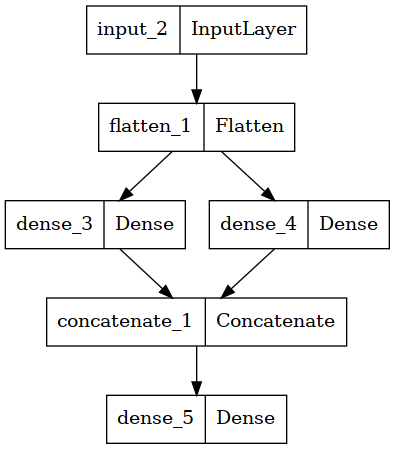

In [8]:
# Compute the average of the images of 0 to use as a mask
mask0 = np.average(train_images[np.where(train_labels==0)],axis=0).reshape((28*28,1))
mask1 = 1 - mask0

# Build a model with only 3 trainable parameters using our masks to identify 0s
def ZeroOrNot_3p(x = 'mnist_0_model_3p'):
    """Generates a model with input shape (28,28) and output shape (1)
    The model has 3 trainable parameters w0, w1 and b:
    Input x --> output = sigmoid( w0*mask0(x) + w1*mask1(x) + b )
    """
    mnist_0_input = layers.Input(shape=(28,28,))
    mnist_0_flatten = layers.Flatten()(mnist_0_input)
    mnist_0_mask_0 = layers.Dense(1)(mnist_0_flatten)
    mnist_0_mask_1 = layers.Dense(1)(mnist_0_flatten)
    mnist_0_concat = layers.Concatenate()([mnist_0_mask_0,mnist_0_mask_1])
    mnist_0_output = layers.Dense(1, activation="sigmoid")(mnist_0_concat)
    #
    mnist_0_model_3p = keras.Model(inputs = mnist_0_input, 
                                   outputs = mnist_0_output, 
                                   name = x)
    #
    # Set the weights of the mask layers
    mnist_0_model_3p.layers[2].set_weights([mask0, np.zeros(1)])
    mnist_0_model_3p.layers[3].set_weights([mask1, np.zeros(1)])
    #
    # Set the mask layers as not trainable
    mnist_0_model_3p.layers[2].trainable = False
    mnist_0_model_3p.layers[3].trainable = False
    #
    return mnist_0_model_3p

mnist_0_model_3p = ZeroOrNot_3p()
# Plot the DAG for this model
keras.utils.plot_model(mnist_0_model_3p, to_file=home_dir+'/tmp/mnist_0_model_3p.png')

Note that we had to use 4 layers to implement a very simple operation:

output = sigmoid(w0 * dot(input, mask0) + w1 * dot(input, mask1) + b)

This unnecessarily clutters our model, specially if we need to repeat this pattern multiple times. Instead we can simply define a keras layer that implements this simple operation.

In [11]:
# Create a subclass of Layer that applies our simple operation
# output = sigmoid(w0 * dot(input, mask0) + w1 * dot(input, mask1) + b)
# We will make the layer more general to allow for generalization.

class reduced_dense(keras.layers.Layer):
    """Subclass of keras.layers.Layer which takes as arguments
    'masks' a numpy array of shape (input_shape, number of masks)
    'units' determines the shape of the output (units,).
    """
    def __init__(self, masks, units=1, activation=tf.nn.sigmoid):
        # Initializer of our class object
        #
        super().__init__()
        # Initializes by calling the initializer of the parent class
        #
        self.units = units
        self.activation = activation
        self.masks = masks
        self.number_of_masks = masks.shape[-1]
        #
    def build(self, input_shape):
        # Builds the layer object and initializes the weights
        #
        dim = self.number_of_masks
        self.w = self.add_weight(shape = (dim,self.units), initializer="random_normal")
        self.b = self.add_weight(shape = (self.units,), initializer="zeros")
        #
    def call(self, inputs):
        # Evaluates the output of the layer
        # sigmoid( (input @ mask0) @ w + b )
        y = tf.matmul( tf.matmul(inputs, self.masks) , self.w) + self.b
        return self.activation(y)
    #
    # Note: For serialization you also need to define the functions 
    # get_config and from_config.
    # 

Model: "mnist_0_simplified_3p"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 reduced_dense (reduced_dens  (None, 1)                3         
 e)                                                              
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


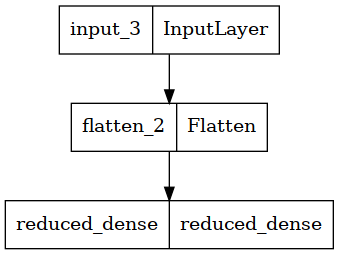

In [12]:
# Using the subclassed layer our model declutters substantially
mask0 = np.average(train_images[np.where(train_labels==0)],axis=0).reshape((28*28,1))
masks = np.concatenate([mask0, 1-mask0], axis=1)

# Build a model with only 3 trainable parameters using our masks to identify 0s
def ZeroOrNot_simplified_3p(masks, x = 'mnist_0_simplified_3p'):
    # Generates a model with input shape (28,28) and output shape (1)
    # The model has 3 trainable parameters w0, w1 and b:
    # Input x --> output = sigmoid( w0*mask0(x) + w1*mask1(x) + b )
    mnist_0_input = layers.Input(shape=(28,28,))
    mnist_0_flatten = layers.Flatten()(mnist_0_input)
    mnist_0_output = reduced_dense(masks)(mnist_0_flatten)
    #
    mnist_0_simplified_3p = keras.Model(inputs = mnist_0_input,
                                        outputs = mnist_0_output,
                                        name = x)
    #
    return mnist_0_simplified_3p

mnist_0_simplified_3p = ZeroOrNot_simplified_3p(masks)
#Print out the summary
mnist_0_simplified_3p.summary()
# Plot the DAG for this model
keras.utils.plot_model(mnist_0_simplified_3p, 
                       to_file=home_dir+'/tmp/mnist_0_simplified_3p.png')

In [9]:
# Choose the optimizer, loss function and metrics with which to compile the model.
# We will choose binary crossentropy as the loss function since the labels are 0 or 1
# and the model output is a single number between 0 and 1.
optim0 = "rmsprop"
loss0 = "binary_crossentropy"
metrics0 = ["binary_accuracy"]

mnist_0_simplified_3p.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

# Utilize early stoppping callback.
#
callb0 = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                       patience=3,
                                       restore_best_weights=True
                                      )

# Train the model
#
mnist_0_simplified_3p.fit(train_images, bin_labels(0, train_labels),
                          validation_data = (val_images, bin_labels(0, val_labels)),
                          epochs = 30,
                          batch_size = 256,
                          callbacks = callb0,
                          verbose = 0)

# Check the performance on validation or test datasets
#
mnist_0_simplified_3p.evaluate(val_images, bin_labels(0, val_labels))

313/313 [==============================] - 0s 1ms/step - loss: 0.1101 - binary_accuracy: 0.9678


[0.11012645065784454, 0.9678000211715698]

#### Exercise

Extend our simplified 3-parameter model to the full MNIST problem.

#### Solution

Model: "mnist_model_210p"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 reduced_dense_1 (reduced_de  (None, 10)               210       
 nse)                                                            
                                                                 
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


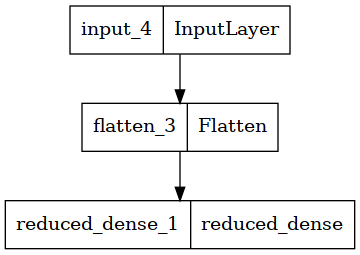

In [10]:
def digit_masks(d):
    # Using the subclassed layer our model declutters substantially
    return np.average(train_images[np.where(train_labels==d)],axis=0).reshape((28*28,1))

masks = []
for i in range(10):
    masks.append(digit_masks(i))
    masks.append(1.0 - digit_masks(i))

masks = np.concatenate(masks, axis=1)

# Build a model with only 3 trainable parameters using our masks to identify 0s
def mnist_model_210p(masks, x = 'mnist_model_210p'):
    # Generates a model with input shape (28,28) and output shape (10)
    # The model has 210 trainable parameters
    # Input x --> output y = softmax( w @ (masks @ x) + b )
    mnist_0_input = layers.Input(shape=(28,28,))
    mnist_0_flatten = layers.Flatten()(mnist_0_input)
    mnist_0_output = reduced_dense(masks,
                                  units = 10,
                                  activation = tf.nn.softmax)(mnist_0_flatten)
    #
    mnist_model_210p = keras.Model(inputs = mnist_0_input,
                                   outputs = mnist_0_output,
                                   name = x)
    #
    return mnist_model_210p

mnist_model_210p = mnist_model_210p(masks)
#Print out the summary
mnist_model_210p.summary()
# Plot the DAG for this model
keras.utils.plot_model(mnist_model_210p, 
                       to_file=home_dir+'/tmp/mnist_model_210p.png')

In [16]:
# Choose the optimizer, loss function and metrics with which to compile the model.
#
# optim1 = "rmsprop"
loss1 = "sparse_categorical_crossentropy"
metrics1 = ["accuracy"]

mnist_model_210p.compile(optimizer = optim0, loss = loss1, metrics = metrics1)

# Utilize early stoppping callback.
#
callb1 = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=5,
                                       restore_best_weights=True
                                      )

# Train the model
#
mnist_model_210p.fit(train_images, train_labels,
                     validation_data = (val_images, val_labels),
                     epochs = 30,
                     batch_size = 256,
                     callbacks = callb1,
                     verbose = 0)

# Check the performance on validation or test datasets
#
mnist_model_210p.evaluate(val_images, val_labels)

313/313 [==============================] - 3s 11ms/step - loss: 0.4760 - accuracy: 0.8569


[0.47595155239105225, 0.8568999767303467]

### Different Training/Inference behavior

A subclassed Layer is capable of behaving differently when called during training and inference. For a good example of this look at the call function of the Dropout layer here:

https://github.com/keras-team/keras/blob/v3.0.0/keras/layers/regularization/dropout.py